In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import random

## Setting up constants

In [2]:
N = 3
num_of_rows = 10 ** N
columns = ['Name', 'Start Date', 'End Date', 'Implementation time']
start_timestamp = 1546300800  # 01-01-2019
end_timestamp = 1577836799  # 31-12-2019
working_hours_start = 8
working_hours_end = 18
working_day_in_hours = working_hours_end - working_hours_start

# 1, 2, 3, 4, 5, 6 и 8 января - Новый год;
# 7 января - Рождество Христово;
# 23 февраля - День защитника Отечества;
# 8 марта - Международный женский день;
# 1 мая - Праздник Весны и Труда;
# 9 мая - День Победы;
# 12 июня - День России;
# 4 ноября - День народного единства.
holidays = [
    dt.datetime(year=2019, month=1, day=1).date(),
    dt.datetime(year=2019, month=1, day=2).date(),
    dt.datetime(year=2019, month=1, day=3).date(),
    dt.datetime(year=2019, month=1, day=4).date(),
    dt.datetime(year=2019, month=1, day=5).date(),
    dt.datetime(year=2019, month=1, day=6).date(),
    dt.datetime(year=2019, month=1, day=7).date(),
    dt.datetime(year=2019, month=1, day=8).date(),
    dt.datetime(year=2019, month=2, day=23).date(),
    dt.datetime(year=2019, month=3, day=8).date(),
    dt.datetime(year=2019, month=5, day=1).date(),
    dt.datetime(year=2019, month=5, day=9).date(),
    dt.datetime(year=2019, month=6, day=12).date(),
    dt.datetime(year=2019, month=11, day=4).date(),
]

## Filling DataFrame with random values

In [3]:
def get_random_date_range():
    start_date_timestamp = random.randint(start_timestamp, end_timestamp)
    start_date = dt.datetime.fromtimestamp(start_date_timestamp).replace(minute=0, second=0)

    end_date_timestamp = random.randint(start_date_timestamp, end_timestamp)
    end_date = dt.datetime.fromtimestamp(end_date_timestamp).replace(minute=0 if random.randint(0, 1) else 30, second=0)

    # random timedelta under 1 week
    # days = random.randint(0, 7)
    # hours = random.randint(0, 23)
    # minutes = 0 if random.randint(0, 1) else 30
    #
    # end_date = start_date + dt.timedelta(days=days,
    #                                      hours=hours,
    #                                      minutes=minutes)

    return start_date, end_date

In [4]:
df = pd.DataFrame(columns=columns)

names = [j for j in range(num_of_rows)]
df['Name'] = names
df.set_index('Name', inplace=True)

start_dates = []
end_dates = []

for j in range(num_of_rows):
    start_date, end_date = get_random_date_range()
    start_dates.append(start_date)
    end_dates.append(end_date)

df['Start Date'] = start_dates
df['End Date'] = end_dates

df.to_csv('data.csv')
print('shape:', df.shape)
df.head()

shape: (1000, 3)


,Start Date,End Date,Implementation time
Name,,,
0,2019-10-06 19:00:00,2019-10-18 06:00:00,NaN
1,2019-04-02 09:00:00,2019-07-26 17:30:00,NaN
2,2019-01-27 05:00:00,2019-10-24 09:00:00,NaN
3,2019-09-04 06:00:00,2019-12-26 11:30:00,NaN
4,2019-09-16 08:00:00,2019-12-26 05:30:00,NaN


## Filling Implementation time column

In [5]:
def get_implementation_time(row):
    start_date = row[0]
    end_date = row[1]

    if start_date.date() == end_date.date():
        if start_date.weekday() not in [5, 6] and start_date.date() not in holidays:
            implementation_time = max(min(end_date.hour + end_date.minute / 60, working_hours_end)
                                      - max(start_date.hour + start_date.minute / 60, working_hours_start), 0)
        else:
            implementation_time = 0
    else:
        implementation_time = 0
        periods = end_date - start_date
        periods = periods.days - 1
        if periods > 0:
            date_list = pd.date_range(start_date.date() + dt.timedelta(days=1), periods=periods).to_pydatetime().tolist()
            date_list = [x for x in date_list if x.weekday() not in [5, 6] and x.date() not in holidays]

            implementation_time += working_day_in_hours * len(date_list)

        if start_date.weekday() not in [5, 6] and start_date.date() not in holidays:
            implementation_time += max(working_hours_end -
                                       max(start_date.hour + start_date.minute / 60, working_hours_start), 0)

        if end_date.weekday() not in [5, 6] and end_date.date() not in holidays:
            implementation_time += max(min(end_date.hour + end_date.minute / 60, working_hours_end)
                                       - working_hours_start, 0)

    row[2] = implementation_time

    return row

In [6]:
df.to_csv('data.csv', header=True)

dateparse = lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
chunk_size = 10 ** 5
for chunk in pd.read_csv('data.csv', chunksize=chunk_size, parse_dates=[1, 2], date_parser=dateparse):
    chunk.set_index('Name', inplace=True)
    chunk = chunk.apply(func=get_implementation_time, axis=1)
    chunk.to_csv('result.csv', mode='a', header=False)

    
dateparse = lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv('result.csv', names=columns, parse_dates=['Start Date', 'End Date'], date_parser=dateparse)
df.set_index('Name', inplace=True)
df.head()

,Start Date,End Date,Implementation time
Name,,,
0,2019-08-23 15:00:00,2019-11-20 22:30:00,623.0
1,2019-07-15 16:00:00,2019-10-01 12:30:00,546.5
2,2019-01-12 09:00:00,2019-06-26 23:00:00,1140.0
3,2019-03-04 03:00:00,2019-11-22 15:30:00,1847.5
4,2019-01-24 14:00:00,2019-03-18 10:30:00,356.5


In [7]:
df['Implementation time'].isna().sum()

0

## Visualization

In [9]:
from collections import Counter

received = Counter()
processed = Counter()

for i, row in df.iterrows():
    start_date = row['Start Date']
    received.update([start_date.month, ])
    
    end_date = row['End Date']
    processed.update([end_date.month, ])

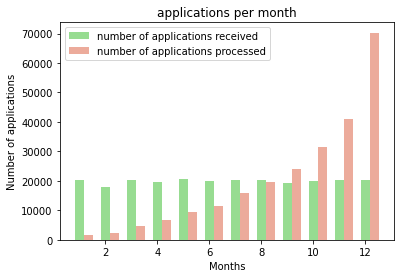

In [10]:
import matplotlib.pyplot as plt

plt.title('applications per month')
plt.xlabel('Months')
plt.ylabel('Number of applications')
width = 0.35
plt.bar(received.keys(), received.values(), width, color='#97dc91', label='number of applications received')
plt.bar(np.array(list(processed.keys())) + width, processed.values(), width, color='#ecab9b', label='number of applications processed')
plt.legend()

## Tests

In [11]:
import unittest


class TestImplementationTime(unittest.TestCase):

    def test_weekends(self):
        """
        Testing implementation time calculating for weekends
        """
        # 2019-01-12 is saturday and 2019-01-13 is sunday
        df = pd.DataFrame(
            [[1, dt.datetime(year=2019, month=1, day=12, hour=0, minute=0), dt.datetime(year=2019, month=1, day=13, hour=23, minute=30), None],
             [2, dt.datetime(year=2019, month=1, day=11, hour=0, minute=0), dt.datetime(year=2019, month=1, day=12, hour=23, minute=30), None],
             [3, dt.datetime(year=2019, month=1, day=13, hour=0, minute=0), dt.datetime(year=2019, month=1, day=14, hour=23, minute=30), None],
             [4, dt.datetime(year=2019, month=1, day=11, hour=0, minute=0), dt.datetime(year=2019, month=1, day=14, hour=23, minute=30), None]],
            columns=columns
        )
    
        df.set_index('Name', inplace=True)
        df = df.apply(func=get_implementation_time, axis=1)
        
        self.assertEqual(df.iloc[0, 2], 0)
        self.assertEqual(df.iloc[1, 2], 10)
        self.assertEqual(df.iloc[2, 2], 10)
        self.assertEqual(df.iloc[3, 2], 20)

    def test_holidays(self):
        """
        Testing implementation time calculating for holidays
        """
        # 2019-06-12 is holiday
        df = pd.DataFrame(
            [[1, dt.datetime(year=2019, month=6, day=12, hour=0, minute=0), dt.datetime(year=2019, month=6, day=12, hour=23, minute=30), None],
             [2, dt.datetime(year=2019, month=6, day=11, hour=0, minute=0), dt.datetime(year=2019, month=6, day=12, hour=23, minute=30), None],
             [3, dt.datetime(year=2019, month=6, day=12, hour=0, minute=0), dt.datetime(year=2019, month=6, day=13, hour=23, minute=30), None],
             [4, dt.datetime(year=2019, month=6, day=11, hour=0, minute=0), dt.datetime(year=2019, month=6, day=13, hour=23, minute=30), None]],
            columns=columns
        )
    
        df.set_index('Name', inplace=True)
        df = df.apply(func=get_implementation_time, axis=1)
        
        self.assertEqual(df.iloc[0, 2], 0)
        self.assertEqual(df.iloc[1, 2], 10)
        self.assertEqual(df.iloc[2, 2], 10)
        self.assertEqual(df.iloc[3, 2], 20)

    def test_non_working_hours(self):
        """
        Testing implementation time calculating for non-working hours
        """
        # working hours is 8-18
        df = pd.DataFrame(
            [[1, dt.datetime(year=2019, month=11, day=20, hour=0, minute=0), dt.datetime(year=2019, month=11, day=20, hour=7, minute=30), None],
             [2, dt.datetime(year=2019, month=11, day=20, hour=0, minute=0), dt.datetime(year=2019, month=11, day=20, hour=9, minute=30), None],
             [3, dt.datetime(year=2019, month=11, day=20, hour=10, minute=0), dt.datetime(year=2019, month=11, day=20, hour=17, minute=0), None],
             [4, dt.datetime(year=2019, month=11, day=20, hour=17, minute=0), dt.datetime(year=2019, month=11, day=20, hour=23, minute=30), None],
             [4, dt.datetime(year=2019, month=11, day=20, hour=18, minute=0), dt.datetime(year=2019, month=11, day=20, hour=23, minute=30), None],
             [4, dt.datetime(year=2019, month=11, day=20, hour=0, minute=0), dt.datetime(year=2019, month=11, day=20, hour=23, minute=30), None]],
            columns=columns
        )
    
        df.set_index('Name', inplace=True)
        df = df.apply(func=get_implementation_time, axis=1)
        
        self.assertEqual(df.iloc[0, 2], 0)
        self.assertEqual(df.iloc[1, 2], 1.5)
        self.assertEqual(df.iloc[2, 2], 7)
        self.assertEqual(df.iloc[3, 2], 1)  
        self.assertEqual(df.iloc[4, 2], 0) 
        self.assertEqual(df.iloc[5, 2], 10)         
        
            
unittest.main(argv=[''], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.020s

OK
